# MNIST classification using using LeNet

In [ ]:
import warnings
from pathlib import Path

import pytorch_hyperlight as pth
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from pytorch_hyperlight.tasks.classification import (
    ClassificationTaskAdamStepLR,
    ClassificationTaskAdamWWarmup,
)
from ray import tune
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets.mnist import MNIST

In [2]:
USAGE_MODE_LIST = [
    "single-run",
    "hyper-opt",
]  # choose from 'single-run' and 'hyper-opt'
# USAGE_MODE = ["hyper-opt"]
# USAGE_MODE = ["single-run"]
FAST_DEV_RUN = False  # if true, simplifed configurations running for just a few epochs are used for making sure there are no obvious bugs

In [3]:
EXPERIMENT_ID = "boring-mnist"

DATASETS_PATH = Path("/home/peter/_Git/_ML/dlschool-solutions/term1/task5/data")

warnings.filterwarnings("ignore")


# a dedicated function for creating datasets
# please note how 'full_train_dataset' is created along with train,
# val and test datasets
def create_datasets(val_size=0.2):
    SEED = 16
    pl.seed_everything(SEED)
    #
    full_train_dataset = MNIST(
        DATASETS_PATH, train=True, download=True, transform=transforms.ToTensor()
    )
    test_dataset = MNIST(
        DATASETS_PATH, train=False, download=True, transform=transforms.ToTensor()
    )
    n_full_train_samples = len(full_train_dataset)
    n_val_samples = int(n_full_train_samples * val_size)
    train_dataset, val_dataset = random_split(
        full_train_dataset, [n_full_train_samples - n_val_samples, n_val_samples]
    )

    n_classes = len(MNIST.classes)

    return {
        "full_train_dataset": full_train_dataset,
        "train_dataset": train_dataset,
        "val_dataset": val_dataset,
        "test_dataset": test_dataset,
        "n_classes": n_classes,
    }

In [4]:
# a dedicated function for creating dataloaders
# 'full_train_loader' is created along with standard 3 loaderers
# for training, validation and testing datasets
def configure_dataloaders(batch_size, n_workers=4, val_size=0.2):
    #
    SHUFFLE = True
    SAMPLER = None
    #
    result_dict = create_datasets(val_size)
    #
    for prefix in ["train", "full_train"]:

        result_dict[f"{prefix}_loader"] = DataLoader(
            result_dict[f"{prefix}_dataset"],
            batch_size=batch_size,
            shuffle=SHUFFLE,
            sampler=SAMPLER,
            num_workers=n_workers,
            pin_memory=True,
        )
    #
    for prefix in ["val", "test"]:
        result_dict[f"{prefix}_loader"] = DataLoader(
            result_dict[f"{prefix}_dataset"],
            batch_size=batch_size,
            shuffle=False,
            num_workers=n_workers,
            pin_memory=True,
        )

    return result_dict

Let us make sure our dataloaders can be created correctly

In [5]:
BATCH_SIZE = 32

loaders_dict = configure_dataloaders(BATCH_SIZE)

loaders_dict

batch = next(iter(loaders_dict["train_loader"]))
assert len(batch[0]) > 0

In [6]:
result_dict = create_datasets(0.2)
len(result_dict["full_train_dataset"])

60000

In [7]:
loaders_dict["n_classes"]

10

### PrettyBoringMNIST

Let define a dedicated class for metrics calculation

In [8]:
class LeNetBoringMNIST(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
class LitPrettyBoringMNIST(ClassificationTaskAdamStepLR):
    def __init__(self, hparams):
        n_classes = hparams["n_classes"]
        model = LeNetBoringMNIST(n_classes)
        criterion = nn.CrossEntropyLoss()
        super().__init__(hparams, model, criterion)

In [10]:
N_CLASSES = loaders_dict["n_classes"]
IS_CUDA = torch.cuda.is_available()
GPU_PER_TRIAL = 0.3 * IS_CUDA

In [11]:
CONFIG = {
    "lr": 1e-3,  # Initial learning rate
    "gradient_clip_val": 0,
    "max_epochs": 6,  # the actual number can be less due to early stopping
    "batch_size": 64,
    "n_classes": N_CLASSES,
    "metric_list": ["f1", "acc", "prec"],
    "lr_step_epochs": 3,
    "lr_step_factor": 0.5,
}

TUNE_CONFIG = {
    "seed": 16,  # just remove this if you do not want determenistic behavior
    "metric_to_optimize": "val_f1_epoch",  # Ray + PTL Trainer
    "ray_metrics_to_show": [
        "val_loss_epoch",
        "val_f1_epoch",
        "val_acc_epoch",
    ],  # for Ray Tune
    "metric_opt_mode": "max",  # Ray + PTL Trainer
    "cpu_per_trial": 3,  # Ray + DataLoaders
    "gpu_per_trial": GPU_PER_TRIAL,  # for Ray Tune
    "n_checkpoints_to_keep": 1,  # for Ray Tune
    "grace_period": 6,  # for both PTL Trainer and Ray Tune scheduler
    "epoch_upper_limit": 45,  # for Ray Tune
    "n_samples": 3,  # for Ray Tune
    "ptl_early_stopping_patience": 7,  # for PTL Trainer
    "ptl_precision": 32,  # or 16, for PTL Trainer
    "train_loader_name": "train_loader",
    "val_loader_name": "val_loader",
    "test_loader_name": "test_loader",
    "batch_size_main": CONFIG[
        "batch_size"
    ],  # batch size for revalidation and test phases
    #    that run in the main process after all Ray Tune child processes are finished
    "gpus": -1 * IS_CUDA,  # -1 - use GPU if available, 0 - use CPU, 1 - use single GPU,
    # >=2 - use multiple GPUs
}

if FAST_DEV_RUN:
    CONFIG["max_epochs"] = 2
    TUNE_CONFIG["n_samples"] = 2

In [12]:
runner = pth.Runner(
    configure_dataloaders,
    is_debug=FAST_DEV_RUN,
    experiment_id=EXPERIMENT_ID,
)

In [13]:
runner.show_metric_report()

In [14]:
runner.get_metrics()

{'run_x_last_metric_df': Empty DataFrame
 Columns: []
 Index: [],
 'epoch_x_stage_run_metric': <pytorch_hyperlight.metrics.trial_metrics.TrialMetrics at 0x7f4d7de97df0>}

In [15]:
best_results_dict = {}

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name              | Type             | Params
-------------------------------------------------------
0 | model             | LeNetBoringMNIST | 60.1 K
1 | criterion         | CrossEntropyLoss | 0     
2 | train_metric_calc | LitMetricsCalc   | 0     
3 | val_metric_calc   | LitMetricsCalc   | 0     
4 | test_metric_calc  | LitMetricsCalc   | 0     
-------------------------------------------------------
60.1 K    Trainable params
0         Non-trainable params
60.1 K    Total params


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       0 |   0.9649 |     0.8794 |    0.9654 |      0.8799 |     0.9653 |       0.8833 | Train/Val |     0.1154 |       0.3787 |


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       1 |   0.9732 |     0.9705 |    0.9737 |      0.9708 |     0.9737 |       0.9706 | Train/Val |     0.0871 |       0.0953 |


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       2 |   0.9803 |     0.9798 |    0.9807 |      0.9799 |     0.9804 |       0.9798 | Train/Val |     0.0641 |       0.0659 |


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       3 |   0.9831 |     0.9863 |    0.9833 |      0.9864 |     0.9833 |       0.9863 | Train/Val |     0.0583 |       0.0435 |


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       4 |   0.9844 |     0.9881 |    0.9846 |      0.9882 |     0.9843 |       0.9881 | Train/Val |     0.0537 |       0.0382 |


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       5 |   0.9848 |     0.9893 |    0.9849 |      0.9894 |      0.985 |       0.9893 | Train/Val |     0.0568 |       0.0332 |


|   epoch |   val_f1 |   reval_f1 |   train_f1 |   val_acc |   reval_acc |   train_acc |   val_prec |   reval_prec |   train_prec | stage   |   val_loss |   reval_loss |   train_loss |
|--------:|---------:|-----------:|-----------:|----------:|------------:|------------:|-----------:|-------------:|-------------:|:--------|-----------:|-------------:|-------------:|
|       5 |   0.9848 |     0.9848 |     0.9893 |    0.9849 |      0.9849 |      0.9894 |      0.985 |        0.985 |       0.9893 | Reval   |     0.0568 |       0.0568 |       0.0332 |


|   epoch |   val_f1 |   train_f1 |   test_f1 |   val_acc |   train_acc |   test_acc |   val_prec |   train_prec |   test_prec | stage   |   val_loss |   train_loss |   test_loss |
|--------:|---------:|-----------:|----------:|----------:|------------:|-----------:|-----------:|-------------:|------------:|:--------|-----------:|-------------:|------------:|
|       5 |   0.9848 |     0.9893 |    0.9876 |    0.9849 |      0.9894 |     0.9876 |      0.985 |       0.9893 |      0.9877 | Test    |     0.0568 |       0.0332 |       0.038 |


,stage,epoch,val_f1,train_f1,val_acc,train_acc,val_prec,train_prec,val_loss,train_loss,reval_f1,reval_acc,reval_prec,reval_loss,test_f1,test_acc,test_prec,test_loss
0,Train/Val,0,0.9649,0.8794,0.9654,0.8799,0.9653,0.8833,0.1154,0.3787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Train/Val,1,0.9732,0.9705,0.9737,0.9708,0.9737,0.9706,0.0871,0.0953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Train/Val,2,0.9803,0.9798,0.9807,0.9799,0.9804,0.9798,0.0641,0.0659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Train/Val,3,0.9831,0.9863,0.9833,0.9864,0.9833,0.9863,0.0583,0.0435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Train/Val,4,0.9844,0.9881,0.9846,0.9882,0.9843,0.9881,0.0537,0.0382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Train/Val,5,0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,0.0332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Reval,5,0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,0.0332,0.9848,0.9849,0.985,0.0568,NaN,NaN,NaN,NaN
7,Test,5,0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,0.0332,NaN,NaN,NaN,NaN,0.9876,0.9876,0.9877,0.038


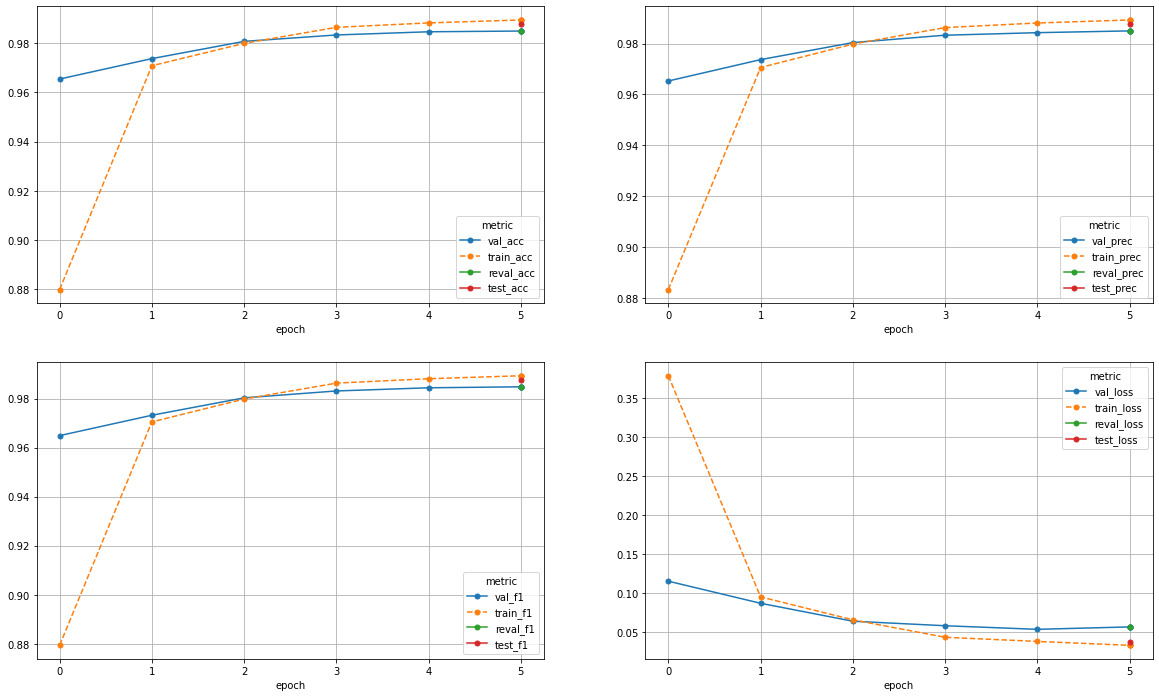

In [16]:
if "single-run" in USAGE_MODE_LIST:
    best_result = runner.run_single_trial(LitPrettyBoringMNIST, CONFIG, TUNE_CONFIG)
    best_result["metrics"].show_report()

### SuperBoringMNIST

In [17]:
class LeNetSimplifiedBoringMNIST(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3)
        self.conv2 = nn.Conv2d(4, 8, 3)
        self.fc1 = nn.Linear(8 * 5 * 5, 30)
        self.fc2 = nn.Linear(30, n_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
class LitSuperBoringMNIST(ClassificationTaskAdamWWarmup):
    def __init__(self, hparams):
        n_classes = hparams["n_classes"]
        model = LeNetSimplifiedBoringMNIST(n_classes)
        criterion = nn.CrossEntropyLoss()
        super().__init__(hparams, model, criterion)

In [19]:
CONFIG = {
    "lr": 1e-3,  # Initial learning rate
    "gradient_clip_val": 0,
    "max_epochs": 6,  # the actual number can be less due to early stopping
    "batch_size": 64,
    "n_classes": N_CLASSES,
    "metric_list": ["f1", "acc", "prec"],
    "warmup": 300,
}

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name              | Type                       | Params
-----------------------------------------------------------------
0 | model             | LeNetSimplifiedBoringMNIST | 6.7 K 
1 | criterion         | CrossEntropyLoss           | 0     
2 | train_metric_calc | LitMetricsCalc             | 0     
3 | val_metric_calc   | LitMetricsCalc             | 0     
4 | test_metric_calc  | LitMetricsCalc             | 0     
-----------------------------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       0 |   0.9289 |     0.7463 |    0.9297 |      0.7385 |     0.9295 |       0.7807 | Train/Val |     0.2297 |       0.7979 |


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       1 |   0.9534 |      0.947 |    0.9539 |      0.9474 |     0.9535 |       0.9471 | Train/Val |     0.1546 |       0.1784 |


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       2 |   0.9633 |     0.9598 |    0.9638 |      0.9601 |     0.9635 |       0.9599 | Train/Val |     0.1222 |       0.1326 |


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       3 |   0.9681 |     0.9664 |    0.9684 |      0.9666 |     0.9683 |       0.9664 | Train/Val |     0.1076 |       0.1099 |


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       4 |   0.9689 |     0.9699 |    0.9692 |      0.9701 |     0.9689 |         0.97 | Train/Val |     0.1004 |       0.0983 |


|   epoch |   val_f1 |   train_f1 |   val_acc |   train_acc |   val_prec |   train_prec | stage     |   val_loss |   train_loss |
|--------:|---------:|-----------:|----------:|------------:|-----------:|-------------:|:----------|-----------:|-------------:|
|       5 |   0.9705 |     0.9722 |    0.9708 |      0.9723 |     0.9705 |       0.9722 | Train/Val |     0.0978 |       0.0908 |


|   epoch |   val_f1 |   reval_f1 |   train_f1 |   val_acc |   reval_acc |   train_acc |   val_prec |   reval_prec |   train_prec | stage   |   val_loss |   reval_loss |   train_loss |
|--------:|---------:|-----------:|-----------:|----------:|------------:|------------:|-----------:|-------------:|-------------:|:--------|-----------:|-------------:|-------------:|
|       5 |   0.9705 |     0.9705 |     0.9722 |    0.9708 |      0.9708 |      0.9723 |     0.9705 |       0.9705 |       0.9722 | Reval   |     0.0978 |       0.0978 |       0.0908 |


|   epoch |   val_f1 |   train_f1 |   test_f1 |   val_acc |   train_acc |   test_acc |   val_prec |   train_prec |   test_prec | stage   |   val_loss |   train_loss |   test_loss |
|--------:|---------:|-----------:|----------:|----------:|------------:|-----------:|-----------:|-------------:|------------:|:--------|-----------:|-------------:|------------:|
|       5 |   0.9705 |     0.9722 |    0.9768 |    0.9708 |      0.9723 |     0.9768 |     0.9705 |       0.9722 |      0.9768 | Test    |     0.0978 |       0.0908 |      0.0794 |


,stage,epoch,val_f1,train_f1,val_acc,train_acc,val_prec,train_prec,val_loss,train_loss,reval_f1,reval_acc,reval_prec,reval_loss,test_f1,test_acc,test_prec,test_loss
0,Train/Val,0,0.9289,0.7463,0.9297,0.7385,0.9295,0.7807,0.2297,0.7979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Train/Val,1,0.9534,0.9470,0.9539,0.9474,0.9535,0.9471,0.1546,0.1784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Train/Val,2,0.9633,0.9598,0.9638,0.9601,0.9635,0.9599,0.1222,0.1326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Train/Val,3,0.9681,0.9664,0.9684,0.9666,0.9683,0.9664,0.1076,0.1099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Train/Val,4,0.9689,0.9699,0.9692,0.9701,0.9689,0.9700,0.1004,0.0983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Train/Val,5,0.9705,0.9722,0.9708,0.9723,0.9705,0.9722,0.0978,0.0908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Reval,5,0.9705,0.9722,0.9708,0.9723,0.9705,0.9722,0.0978,0.0908,0.9705,0.9708,0.9705,0.0978,NaN,NaN,NaN,NaN
7,Test,5,0.9705,0.9722,0.9708,0.9723,0.9705,0.9722,0.0978,0.0908,NaN,NaN,NaN,NaN,0.9768,0.9768,0.9768,0.0794


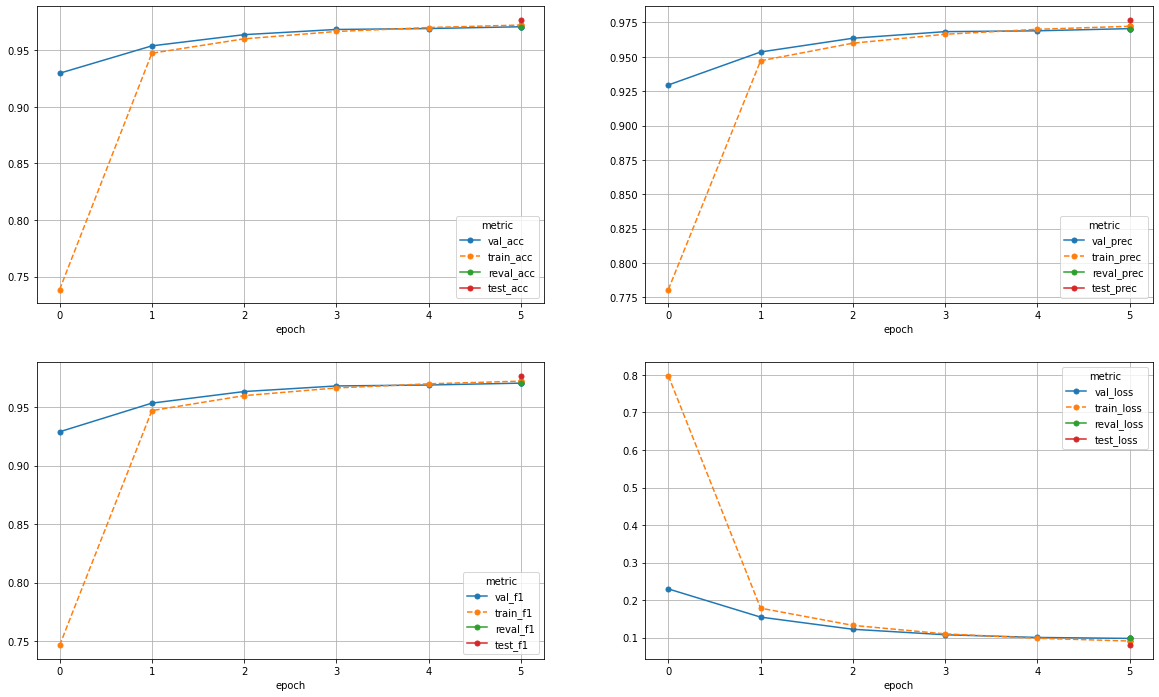

In [20]:
if "single-run" in USAGE_MODE_LIST:
    best_result = runner.run_single_trial(LitSuperBoringMNIST, CONFIG, TUNE_CONFIG)
    best_result["metrics"].show_report()

### Compare metrics for both models

,test_f1,test_acc,run
7,0.9876,0.9876,single-trial-LitPrettyBoringMNIST
7,0.9768,0.9768,single-trial-LitSuperBoringMNIST


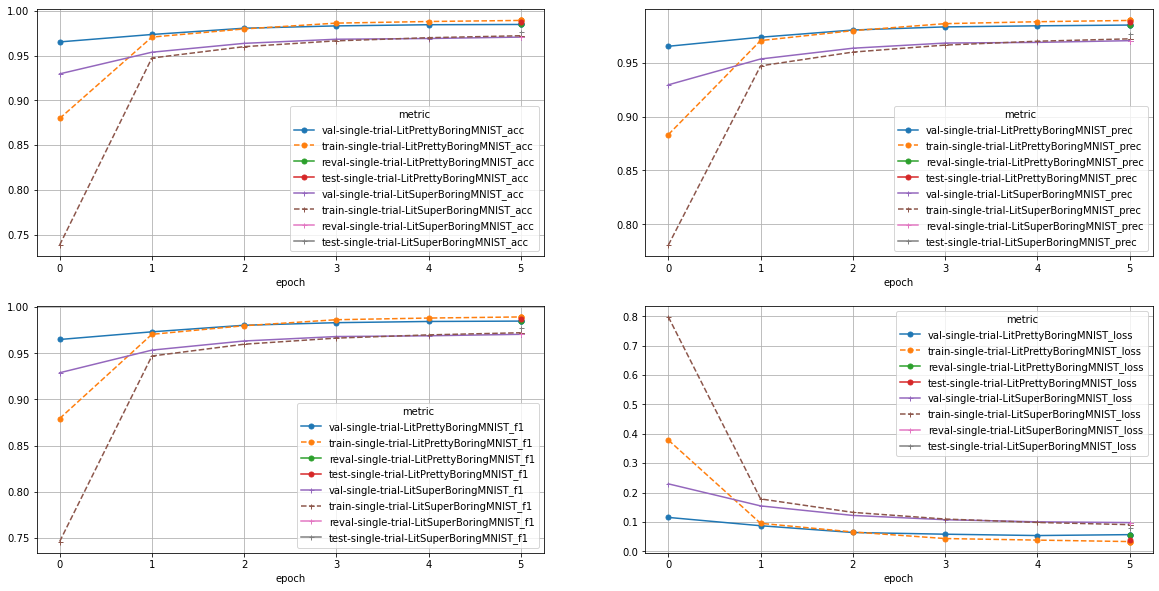

In [21]:
runner.show_metric_report(sort_by_metric_list=["test_f1", "test_acc"])

### Compare training and validation metrics only

,test_acc,test_f1,run
7,0.9876,0.9876,single-trial-LitPrettyBoringMNIST
7,0.9768,0.9768,single-trial-LitSuperBoringMNIST


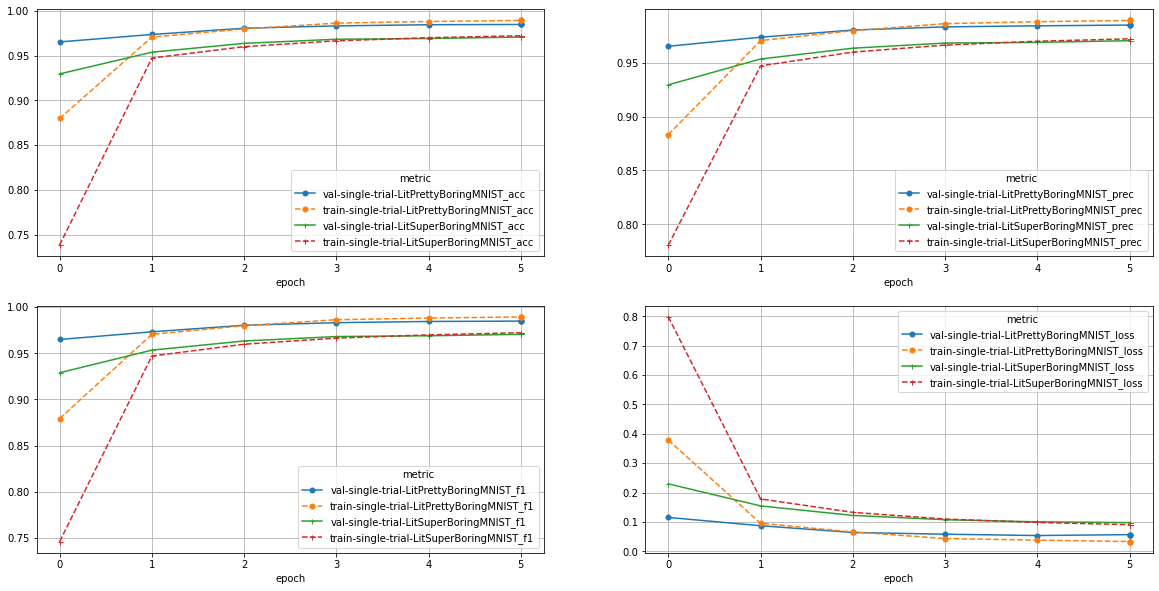

In [22]:
runner.show_metric_report(
    sort_by_metric_list=[
        "test_acc",
        "test_f1",
    ],
    keep_train_val_only=True,
)

### Show all metrics for all previous runs

In [23]:
runner.get_metrics()["epoch_x_stage_run_metric"].df

,stage,epoch,stage-list,val-single-trial-LitPrettyBoringMNIST_f1,train-single-trial-LitPrettyBoringMNIST_f1,val-single-trial-LitPrettyBoringMNIST_acc,train-single-trial-LitPrettyBoringMNIST_acc,val-single-trial-LitPrettyBoringMNIST_prec,train-single-trial-LitPrettyBoringMNIST_prec,val-single-trial-LitPrettyBoringMNIST_loss,...,val-single-trial-LitSuperBoringMNIST_loss,train-single-trial-LitSuperBoringMNIST_loss,reval-single-trial-LitSuperBoringMNIST_f1,reval-single-trial-LitSuperBoringMNIST_acc,reval-single-trial-LitSuperBoringMNIST_prec,reval-single-trial-LitSuperBoringMNIST_loss,test-single-trial-LitSuperBoringMNIST_f1,test-single-trial-LitSuperBoringMNIST_acc,test-single-trial-LitSuperBoringMNIST_prec,test-single-trial-LitSuperBoringMNIST_loss
0,Train/Val,0,"(train, val)",0.9649,0.8794,0.9654,0.8799,0.9653,0.8833,0.1154,...,0.2297,0.7979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Train/Val,1,"(train, val)",0.9732,0.9705,0.9737,0.9708,0.9737,0.9706,0.0871,...,0.1546,0.1784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Train/Val,2,"(train, val)",0.9803,0.9798,0.9807,0.9799,0.9804,0.9798,0.0641,...,0.1222,0.1326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Train/Val,3,"(train, val)",0.9831,0.9863,0.9833,0.9864,0.9833,0.9863,0.0583,...,0.1076,0.1099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Train/Val,4,"(train, val)",0.9844,0.9881,0.9846,0.9882,0.9843,0.9881,0.0537,...,0.1004,0.0983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Train/Val,5,"(train, val)",0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,...,0.0978,0.0908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Reval,5,"(reval,)",0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,...,0.0978,0.0908,0.9705,0.9708,0.9705,0.0978,NaN,NaN,NaN,NaN
7,Test,5,"(test,)",0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,...,0.0978,0.0908,NaN,NaN,NaN,NaN,0.9768,0.9768,0.9768,0.0794


### Run a hyper-parameters search via Ray Tune for PrettyBoringMNIST

In [24]:
SEARCH_SPACE_CONFIG = {
    "unfreeze_epochs": [0, 1],
    "lr": tune.uniform(1e-4, 1e-3),
    "warmup": tune.choice([200, 500, 600]),
    "gradient_clip_val": 0,
    "max_epochs": 6,
    "batch_size": tune.choice([16, 32, 64]),
    "n_classes": N_CLASSES,
}

In [25]:
if FAST_DEV_RUN:
    SEARCH_SPACE_CONFIG["max_epochs"] = 2
    SEARCH_SPACE_CONFIG["batch_size"] = 32

2021-01-11 17:21:17,716	INFO services.py:1171 -- View the Ray dashboard at http://192.168.1.135:8265


== Status ==
Memory usage on this node: 17.6/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 18.000: None | Iter 6.000: None
Resources requested: 3/12 CPUs, 0.0/0 GPUs, 0.0/9.77 GiB heap, 0.0/3.37 GiB objects
Result logdir: /home/peter/ray_results/boring-mnist_11_Jan_2021_17_21_18
Number of trials: 1/3 (1 RUNNING)
+----------------+----------+-------+-------------------+-------------+----------+---------------------+--------------+--------------+-------------+
| Trial name     | status   | loc   | unfreeze_epochs   |          lr |   warmup |   gradient_clip_val |   max_epochs |   batch_size |   n_classes |
|----------------+----------+-------+-------------------+-------------+----------+---------------------+--------------+--------------+-------------|
| inner_45637218 | RUNNING  |       | (0, 1)            | 0.000726156 |      500 |                   0 |            6 |           16 |          10 |
+----------------+----------+-------+-------------------+-------------+------

2021-01-11 17:22:23,345	INFO logger.py:293 -- Removed the following hyperparameter values when logging to tensorboard: {'unfreeze_epochs': (0, 1)}


== Status ==
Memory usage on this node: 19.2/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 18.000: None | Iter 6.000: 0.9168289303779602
Resources requested: 9/12 CPUs, 0.0/0 GPUs, 0.0/9.77 GiB heap, 0.0/3.37 GiB objects
Current best trial: 45637218 with val_f1_epoch=0.965615451335907 and parameters={'unfreeze_epochs': (0, 1), 'lr': 0.0007261562964422965, 'warmup': 500, 'gradient_clip_val': 0, 'max_epochs': 6, 'batch_size': 16, 'n_classes': 10}
Result logdir: /home/peter/ray_results/boring-mnist_11_Jan_2021_17_21_18
Number of trials: 3/3 (3 RUNNING)
+----------------+----------+-----------------------+-------------------+-------------+----------+---------------------+--------------+--------------+-------------+------------------+----------------+-----------------+----------------------+
| Trial name     | status   | loc                   | unfreeze_epochs   |          lr |   warmup |   gradient_clip_val |   max_epochs |   batch_size |   n_classes |   val_loss_epoch |   val

2021-01-11 17:22:52,093	INFO logger.py:293 -- Removed the following hyperparameter values when logging to tensorboard: {'unfreeze_epochs': (0, 1)}


== Status ==
Memory usage on this node: 18.7/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 18.000: None | Iter 6.000: 0.9492711424827576
Resources requested: 6/12 CPUs, 0.0/0 GPUs, 0.0/9.77 GiB heap, 0.0/3.37 GiB objects
Current best trial: 45637218 with val_f1_epoch=0.9737426042556763 and parameters={'unfreeze_epochs': (0, 1), 'lr': 0.0007261562964422965, 'warmup': 500, 'gradient_clip_val': 0, 'max_epochs': 6, 'batch_size': 16, 'n_classes': 10}
Result logdir: /home/peter/ray_results/boring-mnist_11_Jan_2021_17_21_18
Number of trials: 3/3 (2 RUNNING, 1 TERMINATED)
+----------------+------------+-----------------------+-------------------+-------------+----------+---------------------+--------------+--------------+-------------+------------------+----------------+-----------------+----------------------+
| Trial name     | status     | loc                   | unfreeze_epochs   |          lr |   warmup |   gradient_clip_val |   max_epochs |   batch_size |   n_classes |   val

2021-01-11 17:23:41,161	INFO logger.py:293 -- Removed the following hyperparameter values when logging to tensorboard: {'unfreeze_epochs': (0, 1)}
2021-01-11 17:23:41,171	INFO tune.py:448 -- Total run time: 142.73 seconds (142.69 seconds for the tuning loop).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


== Status ==
Memory usage on this node: 18.0/31.3 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 18.000: None | Iter 6.000: 0.9698811570803325
Resources requested: 0/12 CPUs, 0.0/0 GPUs, 0.0/9.77 GiB heap, 0.0/3.37 GiB objects
Current best trial: 45637218 with val_f1_epoch=0.9786589741706848 and parameters={'unfreeze_epochs': (0, 1), 'lr': 0.0007261562964422965, 'warmup': 500, 'gradient_clip_val': 0, 'max_epochs': 6, 'batch_size': 16, 'n_classes': 10}
Result logdir: /home/peter/ray_results/boring-mnist_11_Jan_2021_17_21_18
Number of trials: 3/3 (3 TERMINATED)
+----------------+------------+-------+-------------------+-------------+----------+---------------------+--------------+--------------+-------------+------------------+----------------+-----------------+----------------------+
| Trial name     | status     | loc   | unfreeze_epochs   |          lr |   warmup |   gradient_clip_val |   max_epochs |   batch_size |   n_classes |   val_loss_epoch |   val_f1_epoch |   val_acc_ep

|   epoch |   reval_f1 |   reval_acc | stage   |   reval_loss |
|--------:|-----------:|------------:|:--------|-------------:|
|       0 |     0.9787 |      0.9788 | Reval   |       0.0765 |


|   epoch |   test_f1 |   test_acc | stage   |   test_loss |
|--------:|----------:|-----------:|:--------|------------:|
|       0 |     0.981 |      0.981 | Test    |      0.0596 |


,stage,epoch,reval_f1,reval_acc,reval_loss,test_f1,test_acc,test_loss
0,Reval,6,0.9787,0.9788,0.0765,NaN,NaN,NaN
1,Test,6,NaN,NaN,NaN,0.981,0.981,0.0596


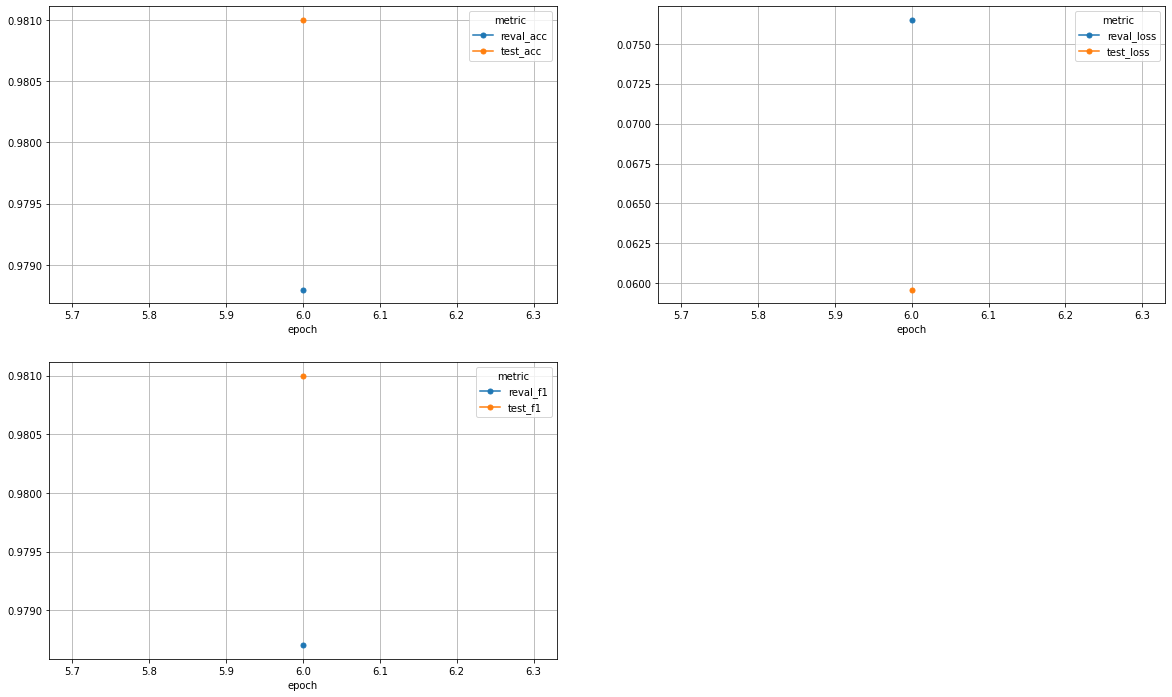

In [26]:
if "hyper-opt" in USAGE_MODE_LIST:
    #
    best_result = runner.run_hyper_opt(
        LitSuperBoringMNIST,
        SEARCH_SPACE_CONFIG,
        TUNE_CONFIG,
    )

    best_result["metrics"].show_report()

### Show all metrics for all previous runs

In [27]:
runner.get_metrics()["epoch_x_stage_run_metric"].df

,stage,epoch,stage-list,val-single-trial-LitPrettyBoringMNIST_f1,train-single-trial-LitPrettyBoringMNIST_f1,val-single-trial-LitPrettyBoringMNIST_acc,train-single-trial-LitPrettyBoringMNIST_acc,val-single-trial-LitPrettyBoringMNIST_prec,train-single-trial-LitPrettyBoringMNIST_prec,val-single-trial-LitPrettyBoringMNIST_loss,...,test-single-trial-LitSuperBoringMNIST_f1,test-single-trial-LitSuperBoringMNIST_acc,test-single-trial-LitSuperBoringMNIST_prec,test-single-trial-LitSuperBoringMNIST_loss,reval-hyper-opt-LitSuperBoringMNIST_f1,reval-hyper-opt-LitSuperBoringMNIST_acc,reval-hyper-opt-LitSuperBoringMNIST_loss,test-hyper-opt-LitSuperBoringMNIST_f1,test-hyper-opt-LitSuperBoringMNIST_acc,test-hyper-opt-LitSuperBoringMNIST_loss
0,Train/Val,0,"(train, val)",0.9649,0.8794,0.9654,0.8799,0.9653,0.8833,0.1154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Train/Val,1,"(train, val)",0.9732,0.9705,0.9737,0.9708,0.9737,0.9706,0.0871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Train/Val,2,"(train, val)",0.9803,0.9798,0.9807,0.9799,0.9804,0.9798,0.0641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Train/Val,3,"(train, val)",0.9831,0.9863,0.9833,0.9864,0.9833,0.9863,0.0583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Train/Val,4,"(train, val)",0.9844,0.9881,0.9846,0.9882,0.9843,0.9881,0.0537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Train/Val,5,"(train, val)",0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Reval,5,"(reval,)",0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Test,5,"(test,)",0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,...,0.9768,0.9768,0.9768,0.0794,NaN,NaN,NaN,NaN,NaN,NaN
8,Reval,6,"(reval,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.9787,0.9788,0.0765,NaN,NaN,NaN
9,Test,6,"(test,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.981,0.981,0.0596


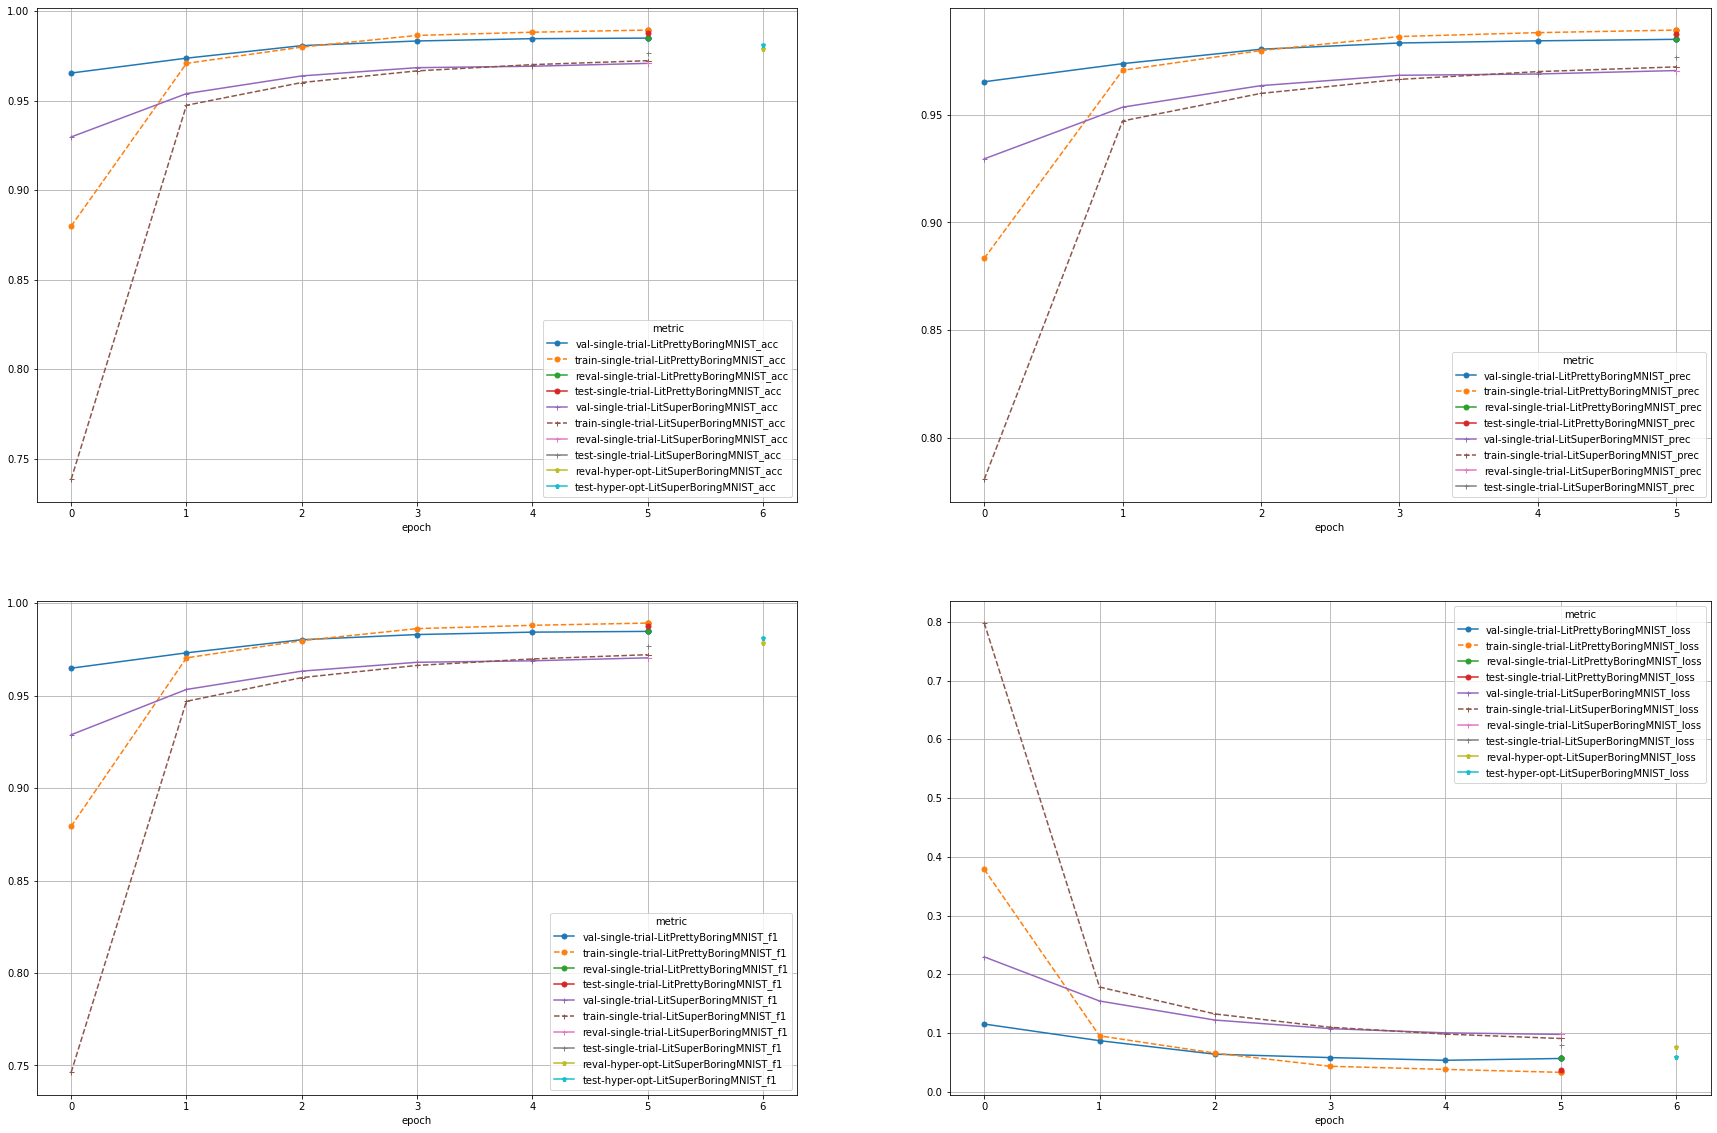

In [28]:
runner.get_metrics()["epoch_x_stage_run_metric"].plot(figsize=(30, 20))

### Re-train PrettyBoringMNIST on all available data with the same hyper-parameters

In [29]:
FT_TUNE_CONFIG = TUNE_CONFIG.copy()
FT_TUNE_CONFIG["val_loader_name"] = None
FT_TUNE_CONFIG["train_loader_name"] = "full_train_loader"
FT_TUNE_CONFIG["metric_to_optimize"] = "train_f1_epoch"

In [30]:
FT_CONFIG = CONFIG.copy()
# FT_CONFIG['max_epochs'] = 19
FT_CONFIG["max_epochs"] = best_result["best_epoch"]

In [31]:
full_train_result = runner.run_single_trial(
    LitSuperBoringMNIST,
    FT_CONFIG,
    FT_TUNE_CONFIG,
    extra_run_name_prefix="full-train-",  # use prefix here to distinguish this run from the previous runs
)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name              | Type                       | Params
-----------------------------------------------------------------
0 | model             | LeNetSimplifiedBoringMNIST | 6.7 K 
1 | criterion         | CrossEntropyLoss           | 0     
2 | train_metric_calc | LitMetricsCalc             | 0     
3 | val_metric_calc   | LitMetricsCalc             | 0     
4 | test_metric_calc  | LitMetricsCalc             | 0     
-----------------------------------------------------------------
6.7 K     Trainable params
0         Non-trainable params
6.7 K     Total params


|   epoch |   train_f1 |   train_acc |   train_prec | stage   |   train_loss |
|--------:|-----------:|------------:|-------------:|:--------|-------------:|
|       0 |     0.7878 |      0.7818 |       0.8113 | Train   |       0.6784 |


|   epoch |   train_f1 |   train_acc |   train_prec | stage   |   train_loss |
|--------:|-----------:|------------:|-------------:|:--------|-------------:|
|       1 |     0.9544 |      0.9547 |       0.9544 | Train   |       0.1518 |


|   epoch |   train_f1 |   train_acc |   train_prec | stage   |   train_loss |
|--------:|-----------:|------------:|-------------:|:--------|-------------:|
|       2 |     0.9659 |      0.9661 |       0.9659 | Train   |       0.1142 |


|   epoch |   train_f1 |   train_acc |   train_prec | stage   |   train_loss |
|--------:|-----------:|------------:|-------------:|:--------|-------------:|
|       3 |     0.9705 |      0.9707 |       0.9705 | Train   |       0.0972 |


|   epoch |   train_f1 |   train_acc |   train_prec | stage   |   train_loss |
|--------:|-----------:|------------:|-------------:|:--------|-------------:|
|       4 |     0.9734 |      0.9735 |       0.9734 | Train   |       0.0868 |


|   epoch |   train_f1 |   train_acc |   train_prec | stage   |   train_loss |
|--------:|-----------:|------------:|-------------:|:--------|-------------:|
|       5 |     0.9761 |      0.9762 |       0.9761 | Train   |       0.0799 |


|   epoch |   train_f1 |   test_f1 |   train_acc |   test_acc |   train_prec |   test_prec | stage   |   train_loss |   test_loss |
|--------:|-----------:|----------:|------------:|-----------:|-------------:|------------:|:--------|-------------:|------------:|
|       5 |     0.9761 |    0.9781 |      0.9762 |     0.9782 |       0.9761 |      0.9782 | Test    |       0.0799 |      0.0679 |


### Show a report comparing both last observed and time-series metrics for LitSuperBoringMNIST model trained on all data

,stage,epoch,train_f1,train_acc,train_prec,train_loss,test_f1,test_acc,test_prec,test_loss
0,Train,0,0.7878,0.7818,0.8113,0.6784,NaN,NaN,NaN,NaN
1,Train,1,0.9544,0.9547,0.9544,0.1518,NaN,NaN,NaN,NaN
2,Train,2,0.9659,0.9661,0.9659,0.1142,NaN,NaN,NaN,NaN
3,Train,3,0.9705,0.9707,0.9705,0.0972,NaN,NaN,NaN,NaN
4,Train,4,0.9734,0.9735,0.9734,0.0868,NaN,NaN,NaN,NaN
5,Train,5,0.9761,0.9762,0.9761,0.0799,NaN,NaN,NaN,NaN
6,Test,5,0.9761,0.9762,0.9761,0.0799,0.9781,0.9782,0.9782,0.0679


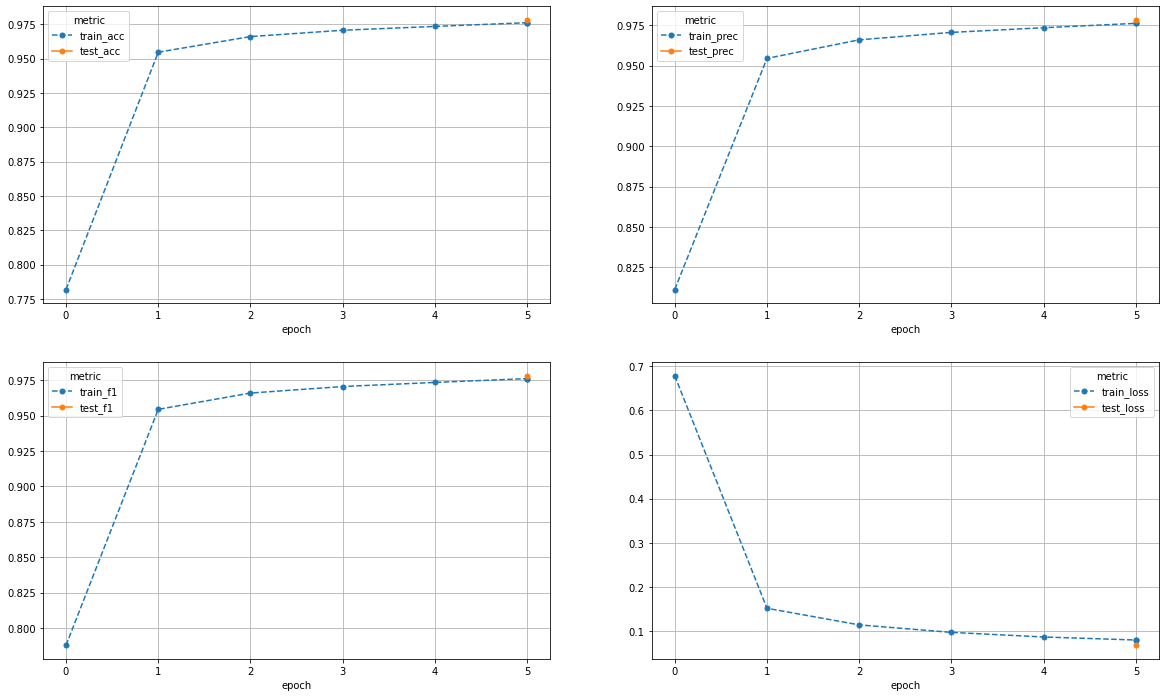

In [32]:
full_train_result["metrics"].show_report()

### Show a report comparing both last observed and time-series metrics for all previous runs

,test_f1,test_acc,run
7,0.9876,0.9876,single-trial-LitPrettyBoringMNIST
1,0.9810,0.9810,hyper-opt-LitSuperBoringMNIST
6,0.9781,0.9782,full-train-single-trial-LitSuperBoringMNIST
7,0.9768,0.9768,single-trial-LitSuperBoringMNIST


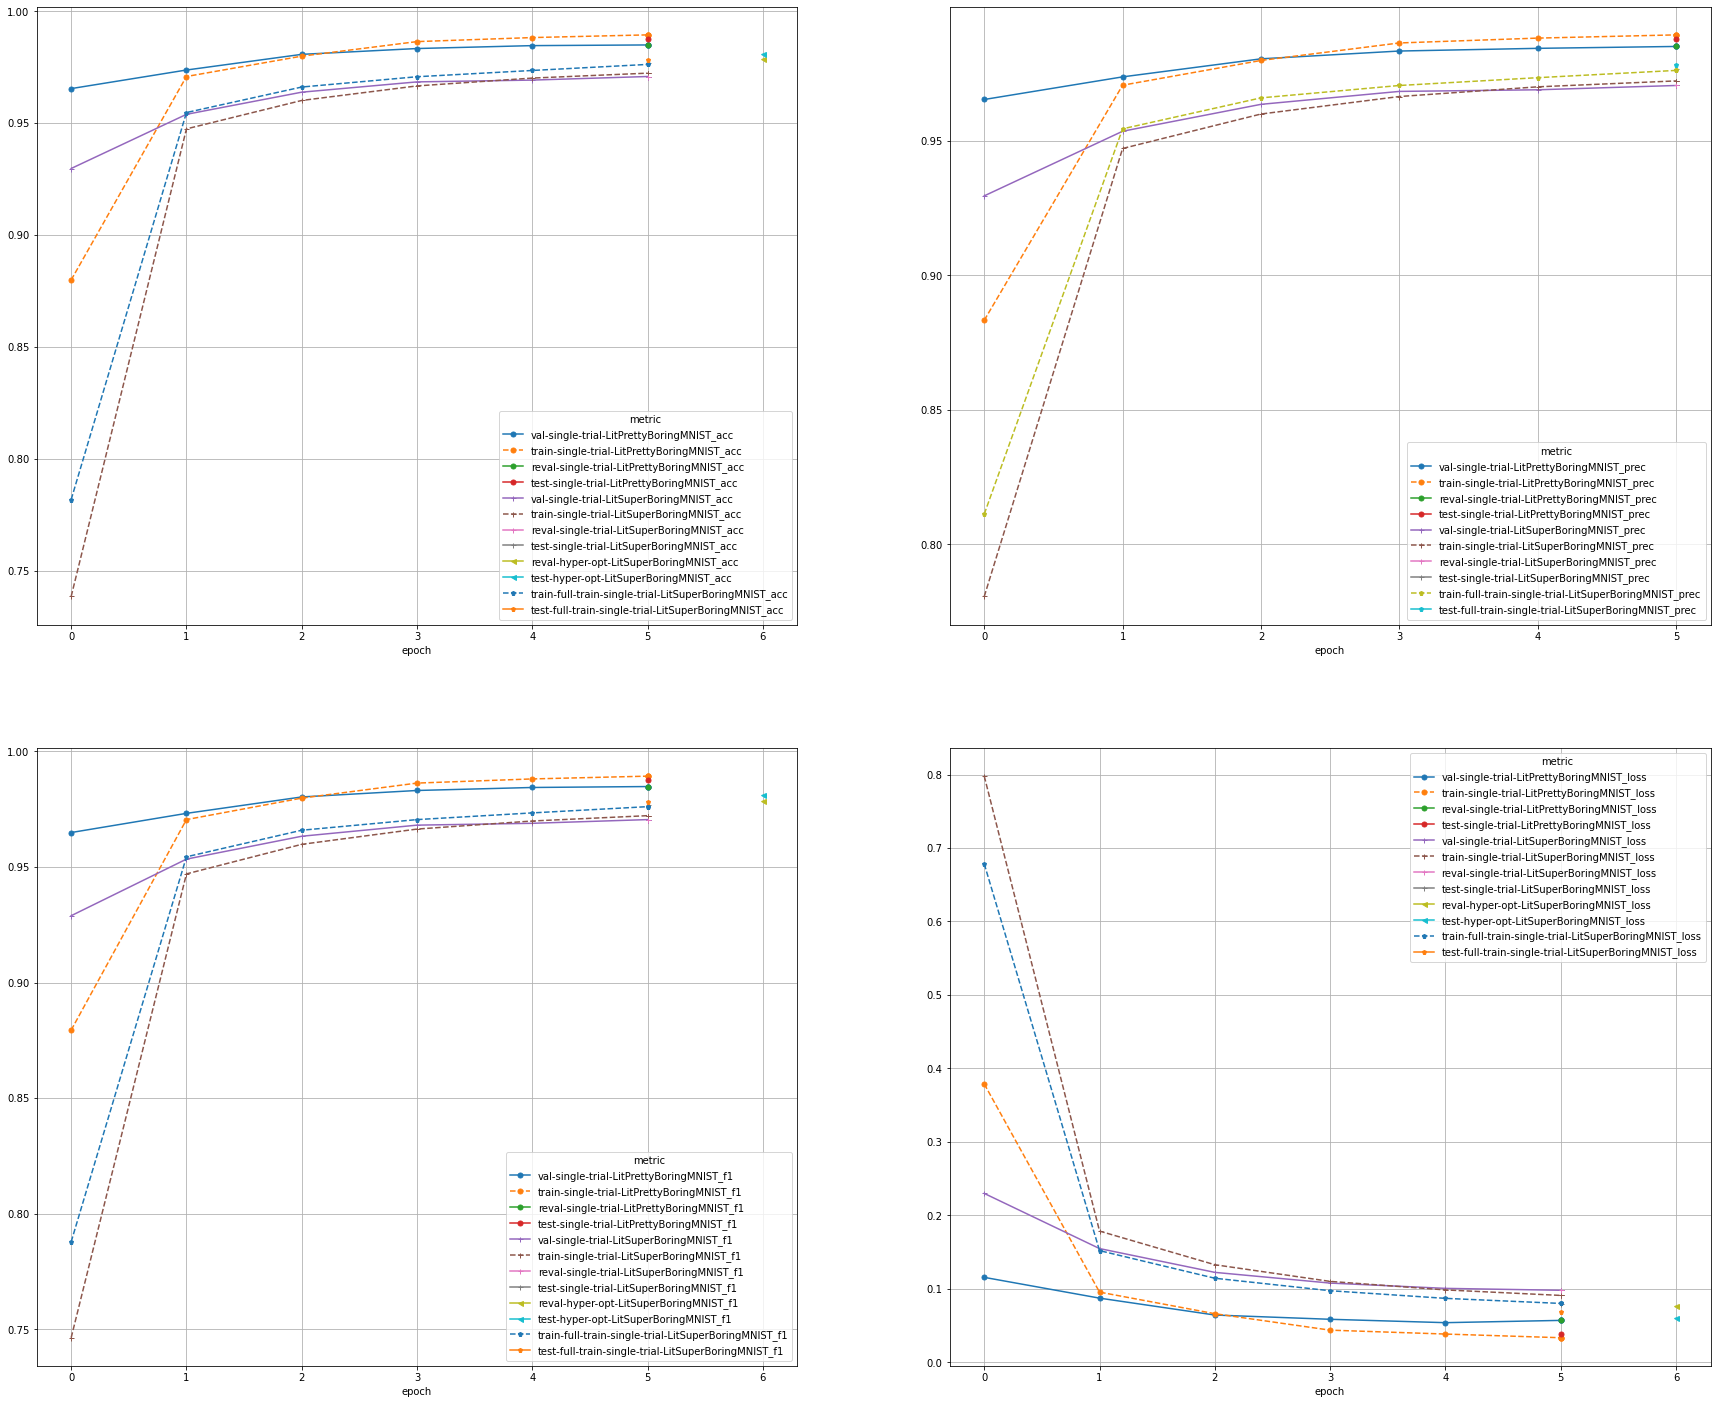

In [33]:
runner.show_metric_report(sort_by_metric_list=["test_f1", "test_acc"], figsize=(30, 25))

### Show all last observed metrics for all previous runs

In [34]:
runner.get_metrics()["run_x_last_metric_df"]

,val_f1,train_f1,val_acc,train_acc,val_prec,train_prec,val_loss,train_loss,reval_f1,reval_acc,reval_prec,reval_loss,test_f1,test_acc,test_prec,test_loss,run
7,0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,0.0332,0.9848,0.9849,0.9850,0.0568,0.9876,0.9876,0.9877,0.0380,single-trial-LitPrettyBoringMNIST
7,0.9705,0.9722,0.9708,0.9723,0.9705,0.9722,0.0978,0.0908,0.9705,0.9708,0.9705,0.0978,0.9768,0.9768,0.9768,0.0794,single-trial-LitSuperBoringMNIST
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9787,0.9788,NaN,0.0765,0.9810,0.9810,NaN,0.0596,hyper-opt-LitSuperBoringMNIST
6,NaN,0.9761,NaN,0.9762,NaN,0.9761,NaN,0.0799,NaN,NaN,NaN,NaN,0.9781,0.9782,0.9782,0.0679,full-train-single-trial-LitSuperBoringMNIST


### Show all time series metrics for all previous runs

In [35]:
runner.get_metrics()["epoch_x_stage_run_metric"].df

,stage,epoch,stage-list,val-single-trial-LitPrettyBoringMNIST_f1,train-single-trial-LitPrettyBoringMNIST_f1,val-single-trial-LitPrettyBoringMNIST_acc,train-single-trial-LitPrettyBoringMNIST_acc,val-single-trial-LitPrettyBoringMNIST_prec,train-single-trial-LitPrettyBoringMNIST_prec,val-single-trial-LitPrettyBoringMNIST_loss,...,test-hyper-opt-LitSuperBoringMNIST_acc,test-hyper-opt-LitSuperBoringMNIST_loss,train-full-train-single-trial-LitSuperBoringMNIST_f1,train-full-train-single-trial-LitSuperBoringMNIST_acc,train-full-train-single-trial-LitSuperBoringMNIST_prec,train-full-train-single-trial-LitSuperBoringMNIST_loss,test-full-train-single-trial-LitSuperBoringMNIST_f1,test-full-train-single-trial-LitSuperBoringMNIST_acc,test-full-train-single-trial-LitSuperBoringMNIST_prec,test-full-train-single-trial-LitSuperBoringMNIST_loss
0,Train/Val,0,"(train, val)",0.9649,0.8794,0.9654,0.8799,0.9653,0.8833,0.1154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Train/Val,1,"(train, val)",0.9732,0.9705,0.9737,0.9708,0.9737,0.9706,0.0871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Train/Val,2,"(train, val)",0.9803,0.9798,0.9807,0.9799,0.9804,0.9798,0.0641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Train/Val,3,"(train, val)",0.9831,0.9863,0.9833,0.9864,0.9833,0.9863,0.0583,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Train/Val,4,"(train, val)",0.9844,0.9881,0.9846,0.9882,0.9843,0.9881,0.0537,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Train/Val,5,"(train, val)",0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Reval,5,"(reval,)",0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Test,5,"(test,)",0.9848,0.9893,0.9849,0.9894,0.9850,0.9893,0.0568,...,NaN,NaN,0.9761,0.9762,0.9761,0.0799,0.9781,0.9782,0.9782,0.0679
8,Reval,6,"(reval,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Test,6,"(test,)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.981,0.0596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
